<a href="https://colab.research.google.com/github/gowrishankarj/customer-conversion-prediction/blob/main/Customer_Purchase_Probability_Persona_Classifier_XGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#Set Current working directory
%cd '/content/drive/My Drive/FourthBrain/Capstone Project'

/content/drive/My Drive/FourthBrain/Capstone Project


Data Set source - S3 bucket (Original source Kaggle)

Install Libraries - S3 Access

In [3]:
!pip install awscli
!pip install fsspec
!pip install s3fs
!pip install squarify

     |████████████████████████████████| 3.8 MB 13.8 MB/s 
     |████████████████████████████████| 79 kB 7.1 MB/s 
     |████████████████████████████████| 8.1 MB 43.9 MB/s 
     |████████████████████████████████| 547 kB 51.5 MB/s 
     |████████████████████████████████| 138 kB 69.1 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
  Attempting uninstall: docutils
    Found existing installation: docutils 0.18
    Uninstalling docutils-0.18:
      Successfully uninstalled docutils-0.18
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
requests 2.23.0 requires urllib3!=1.25.0,!=1.25.1,<1.26,>=1.21.1, but you have urllib3 1.26.7 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
     |██████

Install Latest Version of Spark

In [4]:
import os

#Set Env variables for Spark Initialization
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/drive/My Drive/FourthBrain/Capstone Project/spark-3.2.0-bin-hadoop3.2/"

!apt-get install openjdk-8-jdk-headless -qq > /dev/null
#!wget -q http://apache.osuosl.org/spark/spark-3.2.0/spark-3.2.0-bin-hadoop3.2.tgz
#!tar xf spark-3.2.0-bin-hadoop3.2.tgz
!pip install -q findspark

Import Libraries

In [5]:
import numpy as np
import datetime as dt
import pandas as pd
import numpy as np

from numpy import asarray
from datetime import datetime
import matplotlib.pyplot as plt
import squarify
import findspark
findspark.init()

import pyspark.pandas as ps
import pyspark
import random
from pyspark.sql import SparkSession

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from xgboost import plot_importance
from sklearn.utils import resample
from sklearn import metrics

from sklearn.multiclass import OneVsRestClassifier
from xgboost import XGBClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix

AWS CLI keys

In [6]:
!export AWS_SHARED_CREDENTIALS_FILE=/content/drive/MyDrive/config/awscli.ini

path = "/content/drive/MyDrive/config/awscli.ini"
os.environ['AWS_SHARED_CREDENTIALS_FILE'] = path
print(os.environ['AWS_SHARED_CREDENTIALS_FILE'])

/content/drive/MyDrive/config/awscli.ini


Spark Installation

In [ ]:
spark = SparkSession.builder.master("local[*]").getOrCreate()

View Data Files in S3

In [ ]:
#View Files in S3
!aws s3 ls s3://2021-july-mle-groupby-team/rmf-segmentation/ --recursive --human-readable --summarize
!aws s3 ls s3://2021-july-mle-groupby-team/ecommerce-events-history-in-cosmetics-shop/ --recursive --human-readable --summarize

In [ ]:
events_data = pd.read_csv('s3://2021-july-mle-groupby-team/ecommerce-events-history-in-cosmetics-shop/2020-Jan.csv')
events_data_ps = ps.from_pandas(events_data)
events_data_ps.head()

In [10]:
events_data_featurized = pd.read_csv('s3://2021-july-mle-groupby-team/events-feature-enriched/events_data_clean_persona.csv')
#events_data_featurized = ps.from_pandas(events_data_featurized)
events_data_featurized.head()
events_data_featurized.columns


Index(['Unnamed: 0', 'event_time', 'event_type', 'product_id', 'category_id',
       'category_code', 'brand', 'price', 'user_id', 'user_session',
       'event_date', 'index', 'Recency', 'Frequency', 'Monetary',
       'Customer_Persona'],
      dtype='object')

In [11]:
events_data_featurized['event_type'].unique()

array(['view', 'cart', 'remove_from_cart', 'purchase'], dtype=object)

In [12]:
#activity_count: number of activity in that session

cart_purchase_users = events_data_featurized.loc[events_data_featurized["event_type"].isin(["cart","purchase"])].drop_duplicates(subset=['user_id'])
cart_purchase_users.dropna(how='any', inplace=True)
cart_purchase_users_all_activity = events_data_featurized.loc[events_data_featurized['user_id'].isin(cart_purchase_users['user_id'])]
activity_in_session = cart_purchase_users_all_activity.groupby(['user_session'])['event_type'].count().reset_index()
activity_in_session = activity_in_session.rename(columns={"event_type": "activity_count"})

events_data_featurized = events_data_featurized.merge(activity_in_session, on='user_session', how='left')
events_data_featurized['activity_count'] = events_data_featurized['activity_count'].fillna(0)
events_data_featurized.head()

,Unnamed: 0,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,event_date,index,Recency,Frequency,Monetary,Customer_Persona,activity_count
0,0,2020-01-01 00:00:00 UTC,view,5809910,1602943681873052386,NaN,grattol,5.24,595414620,4adb70bb-edbd-4981-b60f-a05bfd32683a,2020-01-01,170143,677,1,5.24,Lost Customers,0.0
1,1,2020-01-01 00:00:09 UTC,view,5812943,1487580012121948301,NaN,kinetics,3.97,595414640,c8c5205d-be43-4f1d-aa56-4828b8151c8a,2020-01-01,170144,677,1,3.97,Lost Customers,0.0
2,2,2020-01-01 00:00:19 UTC,view,5798924,1783999068867920626,NaN,zinger,3.97,595412617,46a5010f-bd69-4fbe-a00d-bb17aa7b46f3,2020-01-01,170139,677,3,11.75,Customers at risk,0.0
3,3,2020-01-01 00:00:24 UTC,view,5793052,1487580005754995573,NaN,NaN,4.92,420652863,546f6af3-a517-4752-a98b-80c4c5860711,2020-01-01,23312,647,62,469.72,Top Customers,0.0
4,4,2020-01-01 00:00:25 UTC,view,5899926,2115334439910245200,NaN,NaN,3.92,484071203,cff70ddf-529e-4b0c-a4fc-f43a749c0acb,2020-01-01,50307,677,1,3.92,Lost Customers,0.0


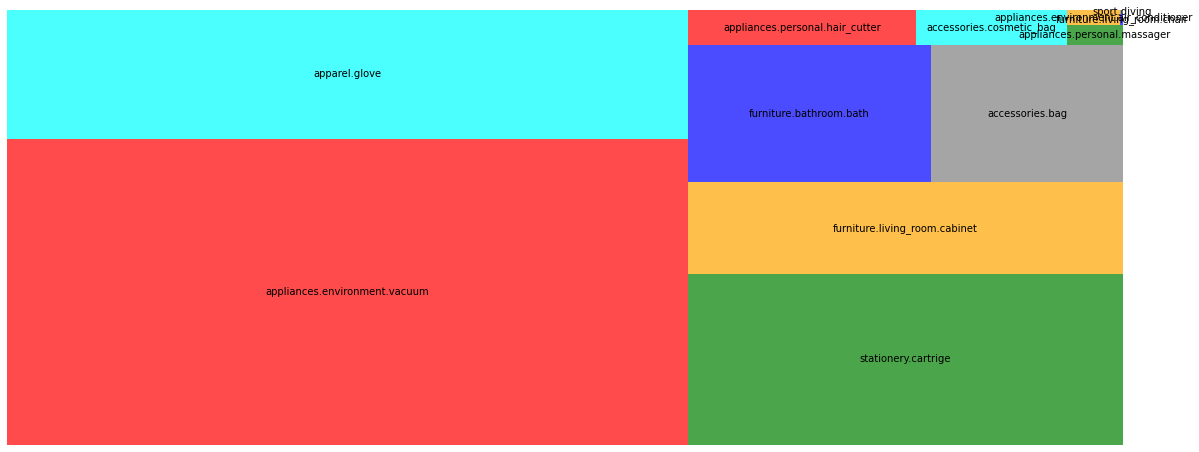

In [50]:
top_category_n = 30
top_category = events_data_featurized['category_code'].value_counts()[:top_category_n].sort_values(ascending=False)
df = pd.DataFrame({'count':top_category, 'top_category':top_category })

squarify.plot(sizes=top_category, label=top_category.index.array, color=["red","cyan","green","orange","blue","grey"], alpha=.7  )
plt.rcParams['figure.figsize'] = (30,12)
plt.axis('off')

plt.show()

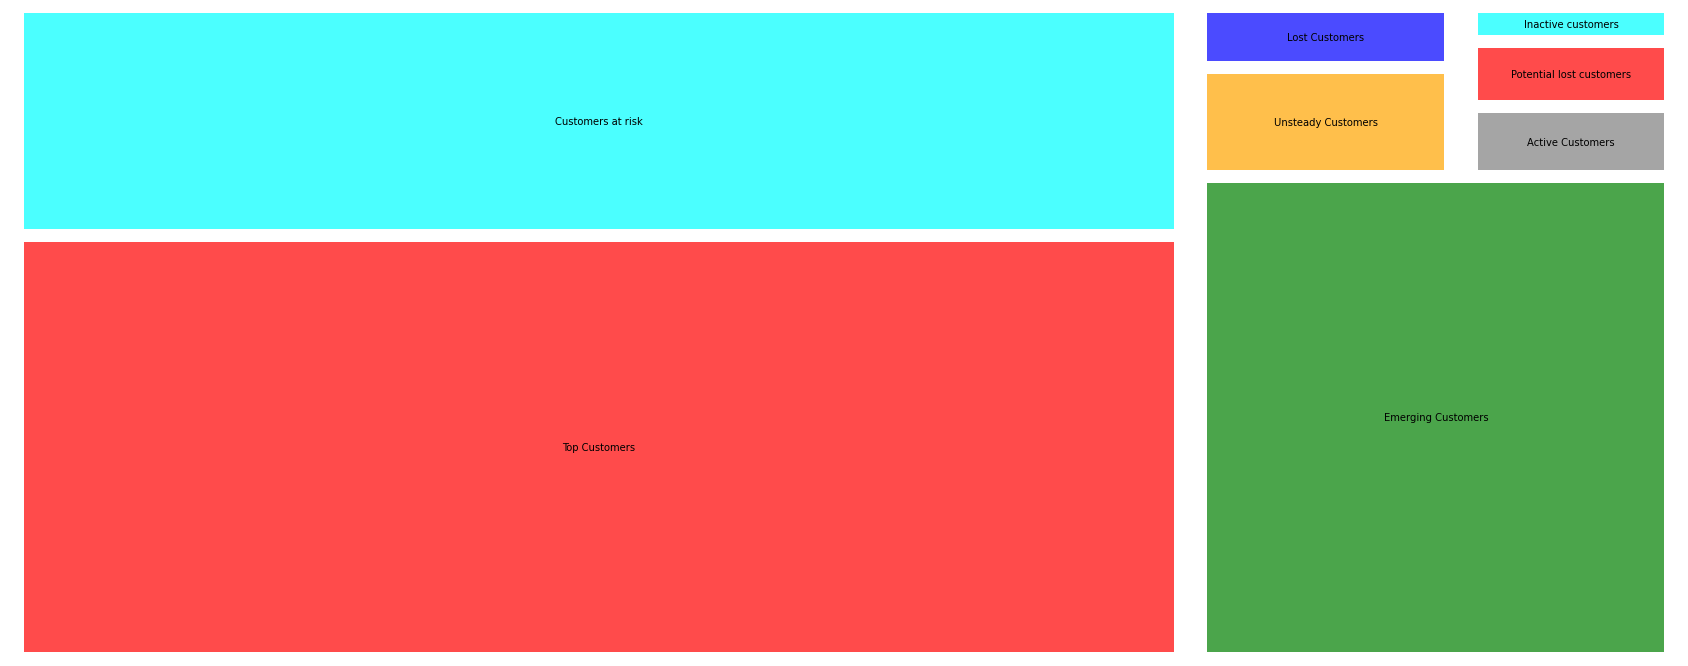

In [51]:
top_category_n = 20
top_category = events_data_featurized['Customer_Persona'].value_counts()[:top_category_n].sort_values(ascending=False)
df = pd.DataFrame({'count':top_category, 'top_category':top_category })

squarify.plot(sizes=top_category, label=top_category.index.array, color=["red","cyan","green","orange","blue","grey"], alpha=.7, pad=True )
plt.rcParams['figure.figsize'] = (30,12)
plt.axis('off')

plt.show()

In [52]:
events_data_featurized['event_type'].value_counts()



view                2037608
cart                1148323
remove_from_cart     815024
purchase             263797
Name: event_type, dtype: int64

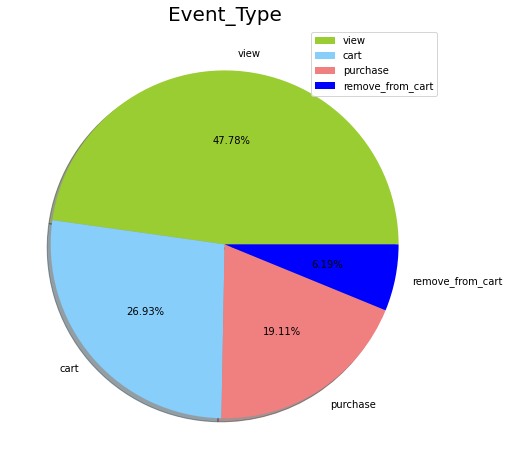

In [28]:
labels = ['view', 'cart','purchase', 'remove_from_cart']
size = events_data_featurized['event_type'].value_counts()
colors = ['yellowgreen', 'lightskyblue','lightcoral','blue']

plt.rcParams['figure.figsize'] = (20, 8)
plt.pie(size, colors = colors, labels = labels, shadow = True, autopct = '%.2f%%')
plt.title('Event_Type', fontsize = 20)
plt.axis('off')
plt.legend()
plt.show()

Encode categorical variables

In [13]:
rfm_segmentation = pd.read_csv('s3://2021-july-mle-groupby-team/rmf-segmentation/RMFSegmentMapping.csv')
rfm_segmentation.head()
Customer_Persona_list =events_data_featurized['Customer_Persona'].unique()
#Customer_Persona_list.reset_index()
Customer_Persona_list = [[k,v] for k,v in enumerate(Customer_Persona_list)]
#print(Customer_Persona_list)



In [14]:
events_data_featurized.dropna(how='any', inplace=True)
print(events_data_featurized.columns)
#events_data_featurized.drop(labels=['category_id','event_time','index','user_session'], axis=1, inplace=True)
events_data_featurized['event_weekday'] = events_data_featurized['event_date'].apply(lambda s: datetime.strptime(s, '%Y-%m-%d').weekday())
events_data_featurized["category_code_level1"] = events_data_featurized["category_code"].str.split(".", expand=True)[0].astype('category')
events_data_featurized["category_code_level2"] = events_data_featurized["category_code"].str.split(".", expand=True)[1].astype('category')
events_data_featurized.head()

Index(['Unnamed: 0', 'event_time', 'event_type', 'product_id', 'category_id',
       'category_code', 'brand', 'price', 'user_id', 'user_session',
       'event_date', 'index', 'Recency', 'Frequency', 'Monetary',
       'Customer_Persona', 'activity_count'],
      dtype='object')


,Unnamed: 0,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,event_date,index,Recency,Frequency,Monetary,Customer_Persona,activity_count,event_weekday,category_code_level1,category_code_level2
359,359,2020-01-01 00:34:35 UTC,view,5743974,1487580013053083824,stationery.cartrige,italwax,1.98,595418733,f2bba423-600f-491d-92e8-975dc3a4b311,2020-01-01,170184,677,2,3.96,Lost Customers,0.0,2,stationery,cartrige
380,380,2020-01-01 00:36:16 UTC,view,5743974,1487580013053083824,stationery.cartrige,italwax,1.98,595418733,f2bba423-600f-491d-92e8-975dc3a4b311,2020-01-01,170184,677,2,3.96,Lost Customers,0.0,2,stationery,cartrige
487,487,2020-01-01 00:44:22 UTC,cart,5856191,1487580006350586771,appliances.environment.vacuum,runail,24.44,530095744,5f9a463e-c3d3-4879-8237-cc88f3225a6f,2020-01-01,78429,671,148,1113.73,Customers at risk,67.0,2,appliances,environment
907,907,2020-01-01 01:16:00 UTC,view,5885596,1487580006350586771,appliances.environment.vacuum,polarus,102.38,459117441,9ea2e135-cbcc-4c79-897b-cd1db49b27c7,2020-01-01,36574,655,182,861.46,Emerging Customers,0.0,2,appliances,environment
987,987,2020-01-01 01:25:02 UTC,cart,5824195,2007399943458784057,apparel.glove,domix,0.94,310843802,e3d3613c-44b4-4a60-8781-d94ad09a1a2a,2020-01-01,6722,651,201,2209.00,Top Customers,0.0,2,apparel,glove


In [15]:
events_data_featurized['Customer_Persona_code']= LabelEncoder().fit_transform(events_data_featurized.loc[:,'Customer_Persona'].copy()).reshape(-1,1)
#Customer_Persona = OneHotEncoder().fit_transform(target).toarray()
print(events_data_featurized['Customer_Persona'])
Customer_Persona =events_data_featurized['Customer_Persona_code']
print(Customer_Persona)
events_data_featurized.loc[:,'event_type'] = LabelEncoder().fit_transform(events_data_featurized.loc[:,'event_type'].copy())

events_data_featurized.loc[:,'brand'] = LabelEncoder().fit_transform(events_data_featurized.loc[:,'brand'].copy())
events_data_featurized.loc[:,'event_weekday'] = LabelEncoder().fit_transform(events_data_featurized.loc[:,'event_weekday'].copy())

events_data_featurized.loc[:,'category_code_level1'] = LabelEncoder().fit_transform(events_data_featurized.loc[:,'category_code_level1'].copy())

events_data_featurized.loc[:,'category_code_level2'] = LabelEncoder().fit_transform(events_data_featurized.loc[:,'category_code_level2'].copy())
#events_data_featurized.drop(labels=['Customer_Persona','event_date','category_code'],axis=1, inplace=True)#
#events_data_featurized.drop(labels=['event_date','category_code'],axis=1, inplace=True)#

359            Lost Customers
380            Lost Customers
487         Customers at risk
907        Emerging Customers
987             Top Customers
                  ...        
4264525         Top Customers
4264534         Top Customers
4264594         Top Customers
4264721      Active Customers
4264738      Active Customers
Name: Customer_Persona, Length: 57768, dtype: object
359        4
380        4
487        1
907        2
987        6
          ..
4264525    6
4264534    6
4264594    6
4264721    0
4264738    0
Name: Customer_Persona_code, Length: 57768, dtype: int64


In [16]:
lkp_customer_persona = events_data_featurized.loc[:,['Customer_Persona_code','Customer_Persona']]
lkp_customer_persona.drop_duplicates(inplace=True)
print(lkp_customer_persona)
lkp_customer_persona.to_csv('s3://2021-july-mle-groupby-team/rmf-segmentation/Customer_Persona_lookup.csv')

        Customer_Persona_code          Customer_Persona
359                         4            Lost Customers
487                         1         Customers at risk
907                         2        Emerging Customers
987                         6             Top Customers
1426                        3        Inactive customers
98988                       0          Active Customers
352717                      7        Unsteady Customers
571183                      5  Potential lost customers


In [17]:
#event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,event_date,index,Recency,Frequency,Monetary,Customer_Persona
#events_data_featurized.head()
Customer_Persona_np = Customer_Persona.to_numpy()
Customer_Persona_np = Customer_Persona_np.reshape(-1,1)
print(Customer_Persona_np.shape)
print(events_data_featurized.shape)

(57768, 1)
(57768, 21)


In [18]:
#events_data_featurized.drop(labels=['category_id','event_time','index'], axis=1, inplace=True)

#events_data_featurized.drop(labels=['event_date','category_code'],axis=1, inplace=True)
#events_data_featurized.drop(labels=['Unnamed: 0'],axis=1, inplace=True)
#events_data_featurized.drop(labels=['event_date','category_code'],axis=1, inplace=True)
#events_data_featurized.drop(labels=['user_session'],axis=1, inplace=True)

#Drop other features
events_data_featurized.drop(labels=['Unnamed: 0','event_date','category_code','category_id','event_time','index','event_type','product_id','brand','price','user_id','user_session','event_weekday','category_code_level1','category_code_level2','activity_count'],axis=1, inplace=True)


In [20]:
events_data_featurized.drop(labels=['Customer_Persona_code'],axis=1, inplace=True)
events_data_featurized.columns
events_data_featurized.head()

,Recency,Frequency,Monetary
359,677,2,3.96
380,677,2,3.96
487,671,148,1113.73
907,655,182,861.46
987,651,201,2209.00


XG Boost Modeling - Multi Class classifier

In [21]:
X_train, X_test, y_train, y_test = train_test_split(events_data_featurized, 
                                                    Customer_Persona_np, 
                                                    test_size = 0.3, 
                                                    random_state = 0)

In [22]:

# Technique using Multioutput classifier on top of XGBoost
classifier = MultiOutputClassifier(XGBClassifier(reg_lambda = 1.2, reg_alpha = 0.2, booster = 'gbtree'))
#classifier = XGBClassifier(objective='multi:softprob',num_class=19,eval_metric='auc')
clf = Pipeline([('classify', classifier)])

print (clf)

Pipeline(memory=None,
         steps=[('classify',
                 MultiOutputClassifier(estimator=XGBClassifier(base_score=0.5,
                                                               booster='gbtree',
                                                               colsample_bylevel=1,
                                                               colsample_bynode=1,
                                                               colsample_bytree=1,
                                                               gamma=0,
                                                               learning_rate=0.1,
                                                               max_delta_step=0,
                                                               max_depth=3,
                                                               min_child_weight=1,
                                                               missing=None,
                                                               n_est

In [23]:
print(X_train.shape)
print(y_train.shape)

events_data_featurized.head()



(40437, 3)
(40437, 1)


,Recency,Frequency,Monetary
359,677,2,3.96
380,677,2,3.96
487,671,148,1113.73
907,655,182,861.46
987,651,201,2209.00


In [24]:
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [32]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

print(y_test.shape)
print(y_pred.shape)
print(y_test[:,0])
print(y_pred[:,0])

#auc_y1 = roc_auc_score(y_test[:,0],y_pred[:,0], multi_class='ovr',max_fpr=1)
#auc_y2 = roc_auc_score(y_test[:,1],y_pred[:,1])
#auc_y3 = roc_auc_score(y_test[:,2],y_pred[:,2])
#auc_y4 = roc_auc_score(y_test[:,3],y_pred[:,3])
#auc_y5 = roc_auc_score(y_test[:,4],y_pred[:,4])
#print("ROC AUC y1: %.4f, y2: %.4f, y3: %.4f, y4: %.4f, y5: %.4f" % (auc_y1, auc_y2, auc_y3, auc_y4, auc_y5))


cm_y1 = confusion_matrix(y_test[:,0],y_pred[:,0])
cm_y2 = confusion_matrix(y_test[:,1],y_pred[:,1])
cm_y3 = confusion_matrix(y_test[:,2],y_pred[:,2])
cm_y4 = confusion_matrix(y_test[:,3],y_pred[:,3])
cm_y5 = confusion_matrix(y_test[:,4],y_pred[:,4])
print(cm_y1)


cr_y1 = classification_report(y_test[:,0],y_pred[:,0])
cr_y2 = classification_report(y_test[:,1],y_pred[:,1])
cr_y3 = classification_report(y_test[:,2],y_pred[:,2])
cr_y4 = classification_report(y_test[:,3],y_pred[:,3])
cr_y5 = classification_report(y_test[:,4],y_pred[:,4])
print (cr_y1)



Accuracy: 0.99994229992499
(17331, 1)
(17331, 1)
[1 1 6 ... 6 1 2]
[1 1 6 ... 6 1 2]


IndexError: ignored

In [ ]:
#plot_importance(clf, max_num_features=8, importance_type ='gain')
#plt.rcParams['figure.figsize'] = (40,10)
#plt.show()

Customer Conversion probability

In [80]:
events_data_featurized.columns

Index(['Recency', 'Frequency', 'Monetary'], dtype='object')

In [ ]:
events_data_conversion_featurized = events_data_featurized
events_data_conversion_featurized["is_purchased"] = np.where(events_data_featurized["event_type"]=="purchase",1,0)
#events_data_conversion_featurized["is_purchased"] = events_data_conversion_featurized.groupby(["user_session","product_id"])["is_purchased"].transform("max")

In [ ]:
is_purchase_set = events_data_conversion_featurized["is_purchased"] 
is_purchase_set.shape[0]
#not_purchase_set = events_data_conversion_featurized[events_data_conversion_featurized['is_purchased']== 0]
#not_purchase_set.shape[0]
events_data_conversion_featurized.loc[:,'event_type'] = LabelEncoder().fit_transform(events_data_conversion_featurized.loc[:,'event_type'].copy())

events_data_conversion_featurized.loc[:,'brand'] = LabelEncoder().fit_transform(events_data_conversion_featurized.loc[:,'brand'].copy())
events_data_conversion_featurized.loc[:,'event_weekday'] = LabelEncoder().fit_transform(events_data_conversion_featurized.loc[:,'event_weekday'].copy())

events_data_conversion_featurized.loc[:,'category_code_level1'] = LabelEncoder().fit_transform(events_data_conversion_featurized.loc[:,'category_code_level1'].copy())

events_data_conversion_featurized.loc[:,'category_code_level2'] = LabelEncoder().fit_transform(events_data_conversion_featurized.loc[:,'category_code_level2'].copy())
#events_data_conversion_featurized.drop(labels=['is_purchased','event_time','user_session','Customer_Persona','event_date','category_code'],axis=1, inplace=True)#
#events_data_conversion_featurized.drop(labels=['event_date','category_code'],axis=1, inplace=True)#

In [ ]:
events_data_conversion_featurized.columns

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(events_data_conversion_featurized, 
                                                    is_purchase_set, 
                                                    test_size = 0.3, 
                                                    random_state = 0)

In [ ]:
from xgboost import XGBClassifier
model_purch = XGBClassifier(learning_rate=0.1)
model_purch.fit(X_train, y_train)
y_pred = model_purch.predict(X_test)

In [ ]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))
print("fbeta:",metrics.fbeta_score(y_test, y_pred, average='weighted', beta=0.5))

Save the model for API purposes

In [34]:
from joblib import dump, load


In [35]:
dump(clf, '/content/drive/My Drive/FourthBrain/Capstone Project/model_output/Persona_XGBoost_pipeline.joblib') 
#dump(model_purch, '/content/drive/My Drive/FourthBrain/Capstone Project/model_output/Purchase_XGBoost_pipeline.joblib') 
('/content/drive/My Drive/FourthBrain/Capstone Project/model_output/Persona_XGBoost_pipeline.joblib') 


NameError: ignored

In [47]:
cp_predict = pd.DataFrame ({"f0": 12, "f1": 12, "f2": 50}, index=[0])
customer_persona_code_predictions = clf.predict(cp_predict)
predict_value = customer_persona_code_predictions.flatten()[0]
print(customer_persona_code_predictions.flatten(),predict_value)

[6] 6


In [49]:
import sklearn as sk
sk.__version__

'0.22.2.post1'

In [51]:
rfm_segmentation = pd.read_csv('s3://2021-july-mle-groupby-team/rmf-segmentation/RMFSegmentMapping.csv')
rfm_segmentation.head(50)

,RMFSegment,Customer_Persona,Persona_Description
0,111,Top Customers,"current, frequent, large revenues"
1,112,Top Customers,"current, frequent, large revenues"
2,113,Active Customers,continuous revenue
3,114,Active Customers,continuous revenue
4,121,Top Customers,"current, frequent, large revenues"
5,122,Top Customers,"current, frequent, large revenues"
6,123,Active Customers,continuous revenue
7,124,Active Customers,continuous revenue
8,131,Active Customers,continuous revenue
9,132,Active Customers,continuous revenue
